# Install detectron2

In [ ]:
!pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 -f https://download.pytorch.org/whl/torch_stable.html
!pip install pyyaml==5.1

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |██████████████▋                 | 834.1 MB 1.3 MB/s eta 0:12:21tcmalloc: large alloc 1147494400 bytes == 0x39656000 @  0x7f64f30b8615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |██████████████████▌             | 1055.7 MB 1.3 MB/s eta 0:09:28tcmalloc: large alloc 1434370048 bytes == 0x7dcac000 @  0x7f64f30b8615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |███████████████████████▌        | 1336.2 MB 1.2 MB/s eta 0:06:36tcmalloc: large alloc 1792966656 bytes =

In [ ]:
!nvcc --version
#print(torch.__version__, torch.cuda.is_available())

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
#
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

#exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

torch:  1.10 ; cuda:  cu113
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 910 kB/s 
     |████████████████████████████████| 130 kB 5.5 MB/s 
     |████████████████████████████████| 50 kB 2.9 MB/s 
     |████████████████████████████████| 78 kB 9.0 MB/s 
     |████████████████████████████████| 151 kB 67.6 MB/s 
     |████████████████████████████████| 749 kB 68.0 MB/s 
     |████████████████████████████████| 843 kB 47.1 MB/s 
     |████████████████████████████████| 117 kB 66.1 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220512-py3-none-any.whl size=61288 sha256=e01336518c1c1f215cdd764adcc822e1fd01e1e4e5b305a8371cd8416a233a30
  Stored in directory: /root/.cache/pip/wheels/68/20/f9/a11a0dd63f4c13678b2a5ec488e48078756505c7777b75b29e
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=05d195eef000b24b4568058d9f06deae

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Train on a custom dataset

In [ ]:
from detectron2.structures import BoxMode
from tqdm.notebook import tqdm
data_path ='/gdrive/Shareddrives/land-app-public/training_data/'

def get_app_dicts(labels_dir, image_list_file):
  print('getting labels for file ', image_list_file)
  files = open(image_list_file, 'r').read().splitlines()
  #val_files = open(val_file, 'r').read().splitlines()
  #train_file = open(train_file, 'r').read().splitlines()
  annotation_files = os.listdir(labels_dir)
  dataset_dicts = []
  for idx, img in tqdm(enumerate(files),total=len(files)):
    labels_file = os.path.basename(img).split('.')[0]+".txt"
    record = {}
    height, width = cv2.imread(img).shape[:2]
    record["file_name"] = img
    record["image_id"] = idx
    record["height"] = height
    record["width"] = width
    anns = []
    if labels_file in annotation_files:
      labels_file = os.path.join(labels_dir, labels_file)
      for ann in open(labels_file,'r').read().splitlines():
        ann = ann.split(" ")
        cls = 0
        bbox = [float(ann[i]) for i in range(1, 5)]
        #convert from relative coordinates to absolute
        box_width = bbox[2]*width
        box_height = bbox[3]*height
        x_min = bbox[0]*width - box_width/2
        y_min = bbox[1]*height - box_height/2
        bbox = [x_min, y_min, box_width,box_height]
        ann_dict = {
            "bbox": bbox,
            "bbox_mode": BoxMode.XYWH_ABS,
            "category_id": cls
        }
        anns.append(ann_dict)
    record['annotations'] = anns
    dataset_dicts.append(record)
  return dataset_dicts

for d in ["train", "validation", 'test']:
    DatasetCatalog.register("landapp_" + d, lambda d=d: get_app_dicts(os.path.join(data_path,"labels"), os.path.join(data_path,d+'.txt')))
    MetadataCatalog.get("landapp_" + d).set(thing_classes=["application"])
balloon_metadata = MetadataCatalog.get("landapp_train")

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



getting labels for file  /gdrive/Shareddrives/land-app-groundtruth/boxing_task/train.txt


  0%|          | 0/747 [00:00<?, ?it/s]

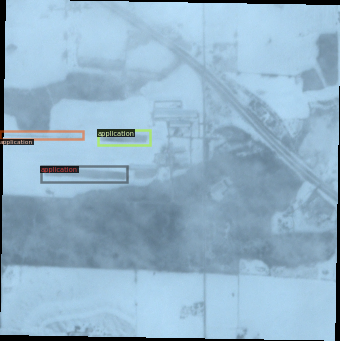

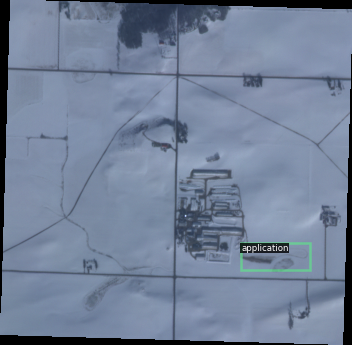

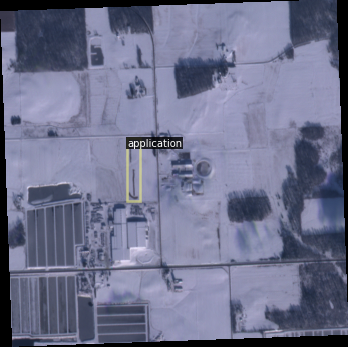

In [ ]:
dataset_dicts = get_app_dicts(os.path.join(data_path,"labels"), os.path.join(data_path,'train.txt'))
train_metadata = MetadataCatalog.get("landapp_train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~2 minutes to train 300 iterations on a P100 GPU.


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, DatasetEvaluators
from detectron2.engine.hooks import BestCheckpointer

def build_evaluator(cfg, dataset_name, output_folder=None):
    """
    Create evaluator(s) for a given dataset.
    This uses the special metadata "evaluator_type" associated with each builtin dataset.
    For your own dataset, you can simply create an evaluator manually in your
    script and do not have to worry about the hacky if-else logic here.
    """
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")

    return COCOEvaluator(dataset_name, output_dir=output_folder)

class Trainer(DefaultTrainer):
    """
    We use the "DefaultTrainer" which contains pre-defined default logic for
    standard training workflow. They may not work for you, especially if you
    are working on a new research project. In that case you can write your
    own training loop. You can use "tools/plain_train_net.py" as an example.
    """

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return build_evaluator(cfg, dataset_name, output_folder)

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("landapp_train",)
cfg.DATASETS.TEST = ("landapp_validation",)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2

cfg.SOLVER.BASE_LR = 0.0005  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (application). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.TEST.EVAL_PERIOD = 200
cfg.OUTPUT_DIR = "/gdrive/Shareddrives/land-app-public/model_weights/faster_RCNN"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg) 

trainer.register_hooks(
    [ BestCheckpointer(cfg.TEST.EVAL_PERIOD, trainer.checkpointer, 'bbox/AP'),]
)
#trainer.resume_or_load(resume=False)
#trainer.train()

[05/18 21:38:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

  0%|          | 0/747 [00:00<?, ?it/s]

[05/18 21:43:40 d2.data.build]: Removed 0 images with no usable annotations. 747 images left.
[05/18 21:43:40 d2.data.build]: Distribution of instances among all 1 categories:
|  category   | #instances   |
|:-----------:|:-------------|
| application | 1285         |
|             |              |
[05/18 21:43:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[05/18 21:43:40 d2.data.build]: Using training sampler TrainingSampler
[05/18 21:43:40 d2.data.common]: Serializing 747 elements to byte tensors and concatenating them all ...
[05/18 21:43:40 d2.data.common]: Serialized dataset takes 0.26 MiB


## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_best.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

getting labels for file  /gdrive/Shareddrives/land-app-groundtruth/boxing_task/validation.txt


  0%|          | 0/107 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


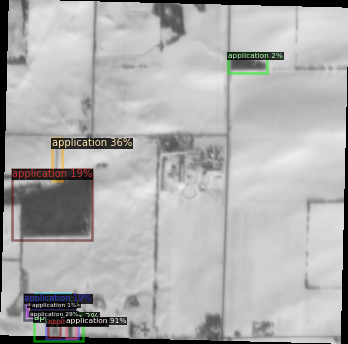

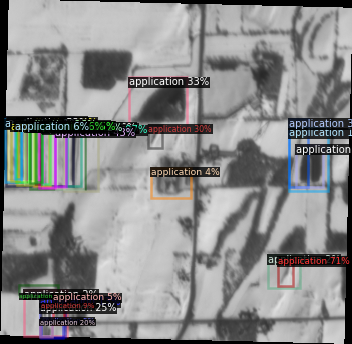

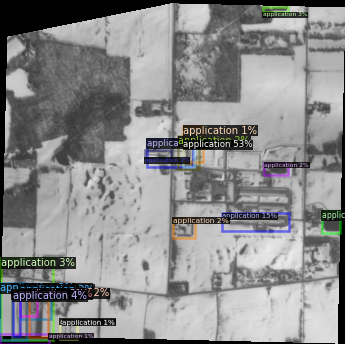

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_app_dicts(os.path.join(data_path,"labels"), os.path.join(data_path,'validation.txt'))
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70. Not bad!

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("landapp_test", output_dir=os.path.join(cfg.OUTPUT_DIR, 'test_set_coco'))
val_loader = build_detection_test_loader(cfg, "landapp_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[05/18 21:49:21 d2.evaluation.coco_evaluation]: Trying to convert 'landapp_test' to COCO format ...
[05/18 21:49:21 d2.data.datasets.coco]: Converting annotations of dataset 'landapp_test' to COCO format ...)
getting labels for file  /gdrive/Shareddrives/land-app-groundtruth/boxing_task/test.txt


  0%|          | 0/207 [00:00<?, ?it/s]

[05/18 21:50:42 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[05/18 21:50:42 d2.data.datasets.coco]: Conversion finished, #images: 207, #annotations: 363
[05/18 21:50:42 d2.data.datasets.coco]: Caching COCO format annotations at '/gdrive/Shareddrives/Land-app-models/faster_rcnn_resnet50_FPN_3x_lr0_0005/test_set_coco/landapp_test_coco_format.json' ...
getting labels for file  /gdrive/Shareddrives/land-app-groundtruth/boxing_task/test.txt


  0%|          | 0/207 [00:00<?, ?it/s]

[05/18 21:50:47 d2.data.build]: Distribution of instances among all 1 categories:
|  category   | #instances   |
|:-----------:|:-------------|
| application | 363          |
|             |              |
[05/18 21:50:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/18 21:50:47 d2.data.common]: Serializing 207 elements to byte tensors and concatenating them all ...
[05/18 21:50:47 d2.data.common]: Serialized dataset takes 0.07 MiB
[05/18 21:50:47 d2.evaluation.evaluator]: Start inference on 207 batches


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/18 21:50:48 d2.evaluation.evaluator]: Inference done 11/207. Dataloading: 0.0027 s/iter. Inference: 0.0605 s/iter. Eval: 0.0002 s/iter. Total: 0.0634 s/iter. ETA=0:00:12
[05/18 21:50:53 d2.evaluation.evaluator]: Inference done 92/207. Dataloading: 0.0036 s/iter. Inference: 0.0580 s/iter. Eval: 0.0003 s/iter. Total: 0.0619 s/iter. ETA=0:00:07
[05/18 21:50:58 d2.evaluation.evaluator]: Inference done 173/207. Dataloading: 0.0035 s/iter. Inference: 0.0581 s/iter. Eval: 0.0003 s/iter. Total: 0.0620 s/iter. ETA=0:00:02
[05/18 21:51:01 d2.evaluation.evaluator]: Total inference time: 0:00:12.574247 (0.062249 s / iter per device, on 1 devices)
[05/18 21:51:01 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:11 (0.058028 s / iter per device, on 1 devices)
[05/18 21:51:01 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/18 21:51:01 d2.evaluation.coco_evaluation]: Saving results to /gdrive/Shareddrives/Land-app-models/faster_rcnn_resnet50_FPN_3x_lr0_00

In [ ]:
trainer.test(cfg, predictor.model, evaluators=(COCOEvaluator("landapp_test", output_dir='./output'),))

getting labels for file  /gdrive/Shareddrives/land-app-groundtruth/boxing_task/test.txt


  0%|          | 0/207 [00:00<?, ?it/s]

[05/13 20:55:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/13 20:55:43 d2.data.common]: Serializing 207 elements to byte tensors and concatenating them all ...
[05/13 20:55:43 d2.data.common]: Serialized dataset takes 0.07 MiB
[05/13 20:55:43 d2.evaluation.evaluator]: Start inference on 207 batches


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[05/13 20:55:44 d2.evaluation.evaluator]: Inference done 11/207. Dataloading: 0.0013 s/iter. Inference: 0.0791 s/iter. Eval: 0.0002 s/iter. Total: 0.0806 s/iter. ETA=0:00:15
[05/13 20:55:49 d2.evaluation.evaluator]: Inference done 73/207. Dataloading: 0.0016 s/iter. Inference: 0.0795 s/iter. Eval: 0.0002 s/iter. Total: 0.0813 s/iter. ETA=0:00:10
[05/13 20:55:54 d2.evaluation.evaluator]: Inference done 136/207. Dataloading: 0.0015 s/iter. Inference: 0.0789 s/iter. Eval: 0.0002 s/iter. Total: 0.0808 s/iter. ETA=0:00:05
[05/13 20:55:59 d2.evaluation.evaluator]: Inference done 198/207. Dataloading: 0.0016 s/iter. Inference: 0.0791 s/iter. Eval: 0.0002 s/iter. Total: 0.0809 s/iter. ETA=0:00:00
[05/13 20:56:00 d2.evaluation.evaluator]: Total inference time: 0:00:16.470456 (0.081537 s / iter per device, on 1 devices)
[05/13 20:56:00 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:15 (0.079189 s / iter per device, on 1 devices)
[05/13 20:56:00 d2.evaluation.coco_evaluation]: 

OrderedDict([('bbox',
              {'AP': 25.736705483983485,
               'AP50': 54.67749151883255,
               'AP75': 20.948876749585516,
               'APl': 29.780547890478005,
               'APm': 26.01409531964654,
               'APs': 10.123055162659124})])

In [ ]:
dataset_dict = get_app_dicts(os.path.join(data_path,"labels"), os.path.join(data_path,'test.txt'))

getting labels for file  /gdrive/Shareddrives/land-app-groundtruth/boxing_task/test.txt


  0%|          | 0/207 [00:00<?, ?it/s]

In [ ]:
classification_task_list = [os.path.join(data_path, "classification_task", 'images', x)+"\n" for x in os.listdir(os.path.join(data_path, "classification_task", 'images'))]

with open(os.path.join(data_path, "classification_task",'images_list.txt'), 'w') as f:
  f.writelines(classification_task_list)

KeyboardInterrupt: ignored

In [ ]:
DatasetCatalog.register("landapp_class_test", lambda : get_app_dicts(os.path.join(data_path,"labels"), os.path.join(data_path,"classification_task",'images_list.txt')))
MetadataCatalog.get("landapp_class_test").set(thing_classes=["application"])

AssertionError: ignored

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("landapp_class_test", output_dir=os.path.join(cfg.OUTPUT_DIR, 'class_test'))
val_loader = build_detection_test_loader(cfg, "landapp_class_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

getting labels for file  /gdrive/Shareddrives/land-app-groundtruth/boxing_task/classification_task/images_list.txt


  0%|          | 0/441 [00:00<?, ?it/s]

[05/16 22:08:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/16 22:08:35 d2.data.common]: Serializing 441 elements to byte tensors and concatenating them all ...
[05/16 22:08:35 d2.data.common]: Serialized dataset takes 0.13 MiB
[05/16 22:08:35 d2.evaluation.evaluator]: Start inference on 441 batches


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[05/16 22:08:36 d2.evaluation.evaluator]: Inference done 11/441. Dataloading: 0.0043 s/iter. Inference: 0.0534 s/iter. Eval: 0.0003 s/iter. Total: 0.0580 s/iter. ETA=0:00:24
[05/16 22:08:41 d2.evaluation.evaluator]: Inference done 96/441. Dataloading: 0.0035 s/iter. Inference: 0.0552 s/iter. Eval: 0.0003 s/iter. Total: 0.0591 s/iter. ETA=0:00:20
[05/16 22:08:46 d2.evaluation.evaluator]: Inference done 180/441. Dataloading: 0.0034 s/iter. Inference: 0.0559 s/iter. Eval: 0.0003 s/iter. Total: 0.0596 s/iter. ETA=0:00:15
[05/16 22:08:51 d2.evaluation.evaluator]: Inference done 264/441. Dataloading: 0.0032 s/iter. Inference: 0.0562 s/iter. Eval: 0.0003 s/iter. Total: 0.0597 s/iter. ETA=0:00:10
[05/16 22:08:56 d2.evaluation.evaluator]: Inference done 345/441. Dataloading: 0.0031 s/iter. Inference: 0.0567 s/iter. Eval: 0.0003 s/iter. Total: 0.0602 s/iter. ETA=0:00:05
[05/16 22:09:01 d2.evaluation.evaluator]: Inference done 429/441. Dataloading: 0.0031 s/iter. Inference: 0.0567 s/iter. Eval: 0

In [ ]:
import pickle
with open('test_dataset.p', 'wb') as f: pickle.dump(dataset_dict, f)

In [ ]:
dataset_dict[0]

{'annotations': [{'bbox': [543.0, 308.0, 35.0, 83.0],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 0}],
 'file_name': '/gdrive/Shareddrives/land-app-groundtruth/boxing_task/images/loc_0050_20200121_160949_0e26_3B_AnalyticMS_clip.png',
 'height': 677,
 'image_id': 0,
 'width': 679}

In [ ]:
dataset_dict = get_app_dicts(os.path.join(data_path,"labels"), os.path.join(data_path,"classification_task",'images_list.txt'))
item_id_dict = {}
for item in dataset_dict:

  item_id_dict[item['image_id']] =item['file_name']

getting labels for file  /gdrive/Shareddrives/land-app-groundtruth/boxing_task/classification_task/images_list.txt


  0%|          | 0/441 [00:00<?, ?it/s]

In [ ]:
import pickle
with open('class_test_image_ids.p', 'wb') as f: pickle.dump(item_id_dict, f)